# 2.2 analysis

In this notebook we explore the performance of Fast Downward planner on 2.2 problems, comparing lazy-greedy and eager-greedy search strategies, both with additive heuristic or causal graph heuristic, or both combined.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import median
from math import sqrt
from numpy import mean
from scipy.stats import sem
from scipy.stats import t
from scipy.stats import wilcoxon
%matplotlib inline
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style="whitegrid")

## Preprocessing

In [2]:
df = pd.read_csv('datasets/22.csv', sep=';')
# merge columns
df['setup'] = df['search-strategy'] + ' ' + df['heuristic']
df['problem'] = df['domain'] + '-' + df['problem'].replace(' ', '_')
df['success'] = df['success (1-success, 0-failure)']
fails = len(df[df['success'] == 0])
perc_fails = fails / len(df.index) * 100
print('fails:', fails)
print('=', perc_fails, '% of', len(df.index))
# drop non-useful cols
df = df.drop(columns=['run-on', 'cost', 'solution-quality', 'coverage', '#', 'success (1-success, 0-failure)'])
df = df.dropna(subset=['generated'])
df = df[df.success == 1]
# correct types and format
df['generated'] = df['generated'].astype(int)
#df['length'] = df['length'].astype(int)
#df['peak-memory (KB)'] = df['peak-memory (KB)'].astype(int)
df['tot-time'] = df['tot-time'].str.replace('s', '').str.replace(',', '.')
df['tot-time'] = df['tot-time'].apply(lambda x: float(x))
df['search-time'] = df['search-time'].str.replace('s', '').str.replace(',', '.')
df['search-time'] = df['search-time'].apply(lambda x: float(x))
df['%expanded'] = df['%expanded'].str.replace(',', '.').str.replace('%', '')
df['%expanded'] = df['%expanded'].apply(lambda x: float(x)/100)
df['%used'] = df['%used'].str.replace(',', '.').str.replace('%', '')
df['%used'] = df['%used'].apply(lambda x: float(x)/100)
df.head()

fails: 62
= 30.392156862745097 % of 204


,domain,problem,heuristic,search-strategy,tot-time,search-time,peak-memory (KB),generated,evaluated,expanded,%expanded,length,%used,dead-ends,setup,success
0,din phil,din phil-instance 1,add,lazy_greedy,0.044187,0.037142,56128.0,63,39.0,38.0,0.6032,18.0,0.4737,0.0,lazy_greedy add,1
1,din phil,din phil-instance 2,add,lazy_greedy,0.002862,0.000932,56260.0,246,112.0,98.0,0.3984,27.0,0.2755,13.0,lazy_greedy add,1
2,din phil,din phil-instance 3,add,lazy_greedy,0.007682,0.005335,56260.0,1434,634.0,428.0,0.2985,36.0,0.0841,205.0,lazy_greedy add,1
3,din phil,din phil-instance 4,add,lazy_greedy,0.020029,0.016852,56260.0,3130,1262.0,723.0,0.2310,71.0,0.0982,538.0,lazy_greedy add,1
4,din phil,din phil-instance 5,add,lazy_greedy,0.041858,0.033940,56392.0,5072,1849.0,953.0,0.1879,70.0,0.0735,895.0,lazy_greedy add,1


## Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 194
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   domain            142 non-null    object 
 1   problem           142 non-null    object 
 2   heuristic         142 non-null    object 
 3   search-strategy   142 non-null    object 
 4   tot-time          142 non-null    float64
 5   search-time       142 non-null    float64
 6   peak-memory (KB)  142 non-null    float64
 7   generated         142 non-null    int64  
 8   evaluated         142 non-null    float64
 9   expanded          142 non-null    float64
 10  %expanded         142 non-null    float64
 11  length            142 non-null    float64
 12  %used             142 non-null    float64
 13  dead-ends         137 non-null    float64
 14  setup             142 non-null    object 
 15  success           142 non-null    int64  
dtypes: float64(9), int64(2), object(5)
memory us

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


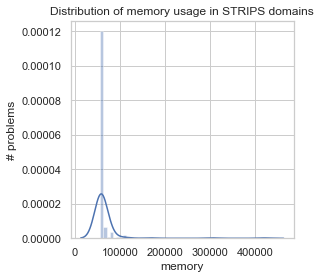

In [4]:
#plt.hist(df['peak-memory (KB)'], 50)
sns.distplot(df['peak-memory (KB)'])
plt.title('Distribution of memory usage in STRIPS domains')
plt.xlabel('memory')
plt.ylabel('# problems')
plt.show()

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


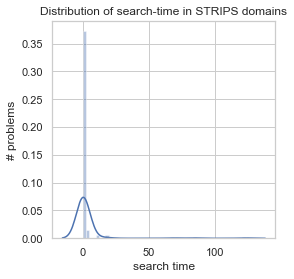

In [5]:
#plt.hist(df['search-time'], 50)
sns.distplot(df['search-time'])
plt.title('Distribution of search-time in STRIPS domains')
plt.xlabel('search time')
plt.ylabel('# problems')
plt.show()

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


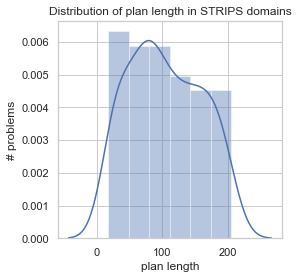

In [6]:
#plt.hist(df['search-time'], 50)
sns.distplot(df['length'])
plt.title('Distribution of plan length in STRIPS domains')
plt.xlabel('plan length')
plt.ylabel('# problems')
plt.show()

In [7]:
df['domain'].value_counts()

din phil    120
opt tel      22
Name: domain, dtype: int64

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


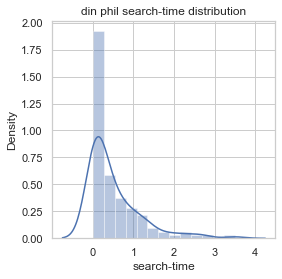

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


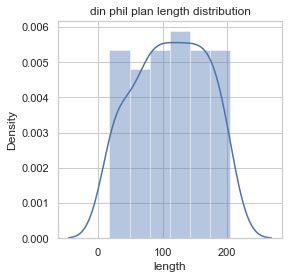

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


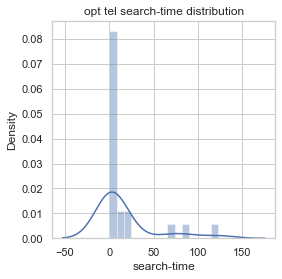

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


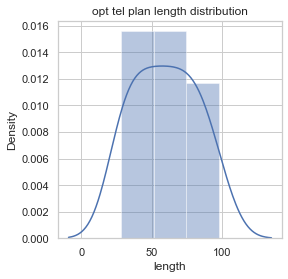

In [8]:
for domain in df['domain'].unique():
    d = df[df['domain'] == domain]
    sns.distplot(d['search-time'])
    title = domain + ' search-time distribution'
    plt.title(title)
    plt.show()
    sns.distplot(d['length'])
    title = domain + ' plan length distribution'
    plt.title(title)
    plt.show()

Only counting how many data remained after removing the unsolved, we are able to capture the most difficult domains. For all of them we ran 20 instances for each setup, except for Optical Telegraph, for which we ran only 14 problems, because the STRIPS repo contained only that number of files.
So, we conclude that Dining Philosopers, Optical Telegraph and PSR are very difficult to solve with a greedy approach and without helpful actions.

## Analysis

In [9]:
lg_add = df[df.setup == 'lazy_greedy add']
lg_cg = df[df.setup == 'lazy_greedy cg']
lg_both = df[df.setup == 'lazy_greedy add+cg']
eg_add = df[df.setup == 'eager_greedy add']
eg_cg = df[df.setup == 'eager_greedy cg']
eg_both = df[df.setup == 'eager_greedy add+cg']

### Functions

In [10]:
def get_stats(d_1, d_2):
    """
    Get the boundaries and the median of a sample
    """
    max_d1 = None
    max_d2 = None
    med_d1 = None
    med_d2 = None
    if len(d_1 > 0):
        max_d1 = d_1.max()
        med_d1 = median(d_1)
    if len(d_2 > 0):
        max_d2 = d_2.max()
        med_d2 = median(d_2)

    if max_d1 == None:
        max_d1 = max_d2
    if max_d2 == None:
        max_d2 = max_d1
        
    if med_d1 == None:
        med_d1 = med_d2
    if med_d2 == None:
        med_d2 = med_d1
        
    return {'max' : max(max_d1, max_d2), 'median' : median([med_d1, med_d2])}
        

In [11]:
def count_fails(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    We count the amount of failed problems in each setup
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    
    #exclude domains 
    if exclude != None:
        for exc in exclude:
            df_1 = df_1[df_1['domain'] != exc]
            df_2 = df_2[df_2['domain'] != exc]
    
    p_1 = df_1.problem.unique()
    p_2 = df_2.problem.unique()
    
    unsolved_1 = 0
    unsolved_2 = 0
    
    for prob_1 in p_1:
        if prob_1 not in p_2:
            unsolved_2 += 1
    for prob_2 in p_2:
        if prob_2 not in p_1:
            unsolved_1 += 1
    return {label_1 : str('{:.2f}'.format(unsolved_1 / len(p_2)*100)) + '%',  label_2 : str('{:.2f}'.format(unsolved_2 /  len(p_1)*100)) + '%' }

In [12]:
def get_difference(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    We count in how many cases first setup does better than 
    the second one and viceversa
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    
    #exclude domains 
    if exclude != None:
        for exc in exclude:
            df_1 = df_1[df_1['domain'] != exc]
            df_2 = df_2[df_2['domain'] != exc]
    
    p_1 = df_1.problem.unique()
    p_2 = df_2.problem.unique()
    
    better_1 = 0
    better_2 = 0
    
    for prob in p_1:
        if prob in p_2:
            if df_1.loc[df_1['problem'] == prob][attr].values[0] < df_2.loc[df_2['problem'] == prob][attr].values[0]:
                better_1 += 1
            else:
                better_2 += 1
        else:
            better_1 += 1
    for prob in p_2:
        if not prob in p_1:
            better_2 += 1
    
    title = attr + ' - ' + label_1 + ' vs ' + label_2
    sns.barplot(x=['better ' + label_1, 'better ' + label_2], y=[better_1, better_2])
    plt.title(title)
    plt.plot()

In [13]:
def plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    Plot the performance comparison between two setups
    according to a specific attribute i.e. search-time
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    points = []
    seen = []
    
    for index, row in df_1.iterrows():
        datum = {}
        problem = row['problem']
        domain = row['domain']

        if len(df_2.loc[df_2['problem'] == problem][attr]) > 0:
            datum['domain'] = domain
            datum[label_1] = row[attr]
            datum[label_2] = df_2.loc[df_2['problem'] == problem][attr].values[0]
        points.append(datum)
    points = pd.DataFrame(points)

    #exclude domains 
    if exclude != None:
        for exc in exclude:
            points = points[points['domain'] != exc]
    # useful data to draw diagonal        
    max_x = points[[label_1]].max()
    max_y = points[[label_2]].max()
    max_t = max(max_x.values, max_y.values)
    
    title = attr + ' - ' + label_1 + ' vs ' + label_2
    #plot the scatter
    sc = sns.scatterplot(data=points, x=label_1, y=label_2, hue='domain', style='domain', alpha=0.5)
    sc.set(xscale='log', yscale='log')
    plt.plot([0, max_t], [0, max_t], linewidth=2)
    plt.title(title)
    plt.show()

In [14]:
def plot_comparison_tolerant(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    Plot the performance comparison between two setups
    according to a specific attribute i.e. search-time
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    points = []
    seen = []
    
    for index, row in df_1.iterrows():
        datum = {}
        problem = row['problem']
        domain = row['domain']

        if len(df_2.loc[df_2['problem'] == problem][attr]) > 0:
            datum['domain'] = domain
            datum[label_1] = row[attr]
            datum[label_2] = df_2.loc[df_2['problem'] == problem][attr].values[0]
        else: 
            datum['domain'] = domain
            datum[label_1] = row[attr]
            stats = get_stats(df_1.loc[df_1['domain'] == domain][attr], df_2.loc[df_2['domain'] == domain][attr])
            #max values
            max_dt = stats['max']
            #find median values
            med_dt = stats['median']
            datum[label_2] = max_dt + med_dt #problem unsolved by first setup
        seen.append(row['problem'])
        points.append(datum)

    if len(df_2) > 0:
        for index, row in df_2.iterrows():
            domain = row['domain']
            datum = {}
            datum['domain'] = domain
            stats = get_stats(df_1.loc[df_1['domain'] == domain][attr], df_2.loc[df_2['domain'] == domain][attr])
            #max values
            max_dt = stats['max']
            #find median values
            med_dt = stats['median']
            datum[label_1] = max_dt + med_dt #problem unsolved by second setup
            datum[label_2] = row[attr]
            points.append(datum)
    points = pd.DataFrame(points)

    #exclude domains 
    if exclude != None:
        for exc in exclude:
            points = points[points['domain'] != exc]
    # useful data to draw diagonal        
    max_x = points[[label_1]].max()
    max_y = points[[label_2]].max()
    max_t = max(max_x.values, max_y.values)
    
    title = attr + ' - ' + label_1 + ' vs ' + label_2
    #plot the scatter
    sc = sns.scatterplot(data=points, x=label_1, y=label_2, hue='domain', style='domain', alpha=0.5)
    sc.set(xscale='log', yscale='log')
    plt.plot([0, max_t], [0, max_t], linewidth=2)
    plt.title(title)
    plt.show()

In [15]:
def wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    Since we don't always have the same solved instances, 
    we have to remove the orphans and only keep the 
    problems solved by both setups
    """
    
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    
    #exclude domains 
    if exclude != None:
        for exc in exclude:
            df_1 = df_1[df_1['domain'] != exc]
            df_2 = df_2[df_2['domain'] != exc]
    
    p_1 = df_1.problem.unique()
    p_2 = df_2.problem.unique()
    
    d_1 = []
    d_2 = []
    
    for prob in p_1:
        if prob in p_2:
            d_1.append(df_1.loc[df_1['problem'] == prob][attr].values[0])
            d_2.append(df_2.loc[df_2['problem'] == prob][attr].values[0])
            
    w, p = wilcoxon(d_1, d_2)
    print('w:', w, '\np:', p)
    if p > 0.05:
        print('Same distribution between', label_1, 'and', label_2, 'in terms of', attr)
    else:
        print('Significant difference between', label_1, 'and', label_2, 'in terms of', attr)

# Analysis of 2.2 Domains
We only have 2 domains, by consequence we analyse them together

## Comparison between heuristics
The couples of setups we compare in the next cells have constant search strategy and different heuristic

### Heuristics in lazy greedy

#### lazy greedy: add vs cg

Time performances

In [16]:
attr = 'search-time'
df_1 = lg_add
df_2 = lg_cg

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

KeyError: "None of [Index(['lg add'], dtype='object')] are in the [columns]"

Count of how many times one setup is better than the other

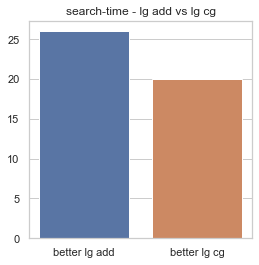

In [17]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

In [18]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

plan length performance

In [19]:
attr = 'length'
df_1 = lg_add
df_2 = lg_cg

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

KeyError: "None of [Index(['lg add'], dtype='object')] are in the [columns]"

In [20]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

Count of how many times one setup is better than the other

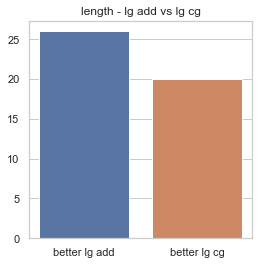

In [21]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

Count of failed problems for each approach

In [22]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg cg')

{'lg add': '100.00%', 'lg cg': '100.00%'}

#### lazy greedy: add vs  both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


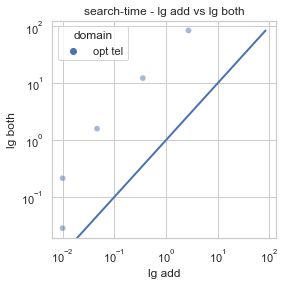

In [23]:
attr = 'search-time'
df_1 = lg_add
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg both')

Count of how many times one setup is better than the other

In [24]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg both')

w: 0.0 
p: 0.0625
Same distribution between lg add and lg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


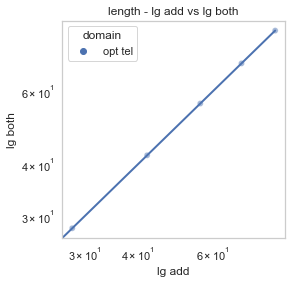

In [25]:
attr = 'length'
df_1 = lg_add
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg both')

Count of how many times one setup is better than the other

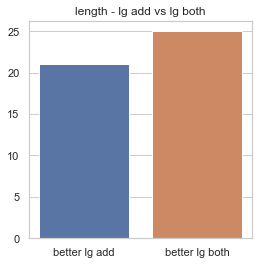

In [26]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg both')

In [27]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg both')

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

Count of failed problems for each approach

In [28]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'lg both')

{'lg add': '80.00%', 'lg both': '80.77%'}

#### Lazy greedy: cg vs both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


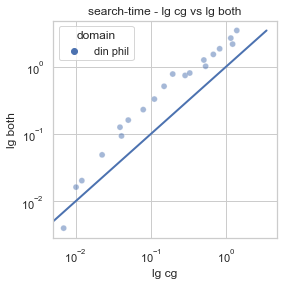

In [29]:
attr = 'search-time'
df_1 = lg_cg
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

Count of how many times one setup is better than the other

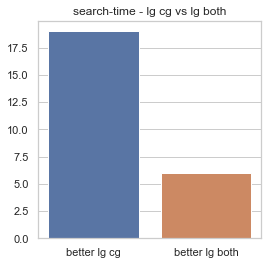

In [30]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

In [31]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

w: 1.0 
p: 3.814697265625e-06
Significant difference between lg cg and lg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


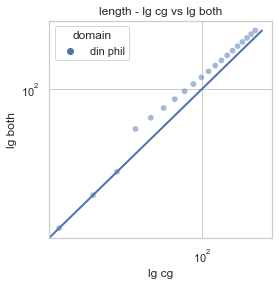

In [32]:
attr = 'length'
df_1 = lg_cg
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

In [33]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

w: 0.0 
p: 3.737981840170154e-05
Significant difference between lg cg and lg both in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Count of how many times one setup is better than the other

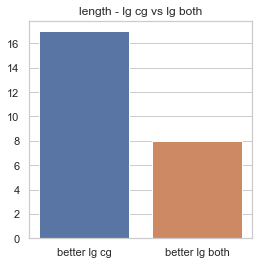

In [34]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

Count of failed problems for each approach

In [35]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'lg both')

{'lg cg': '20.00%', 'lg both': '0.00%'}

### Heuristics in eager greedy

#### eager greedy: add vs cg

Time performances

In [36]:
attr = 'search-time'
df_1 = eg_add
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

KeyError: "None of [Index(['eg add'], dtype='object')] are in the [columns]"

Count of how many times one setup is better than the other

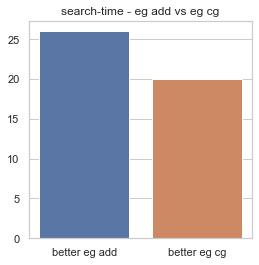

In [37]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

In [38]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

plan length performance

In [39]:
attr = 'length'
df_1 = eg_add
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

KeyError: "None of [Index(['eg add'], dtype='object')] are in the [columns]"

In [40]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

Count of how many times one setup is better than the other

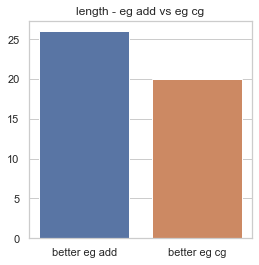

In [41]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

Count of failed problems for each approach

In [42]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg cg')

{'eg add': '100.00%', 'eg cg': '100.00%'}

#### eager greedy: add vs  both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


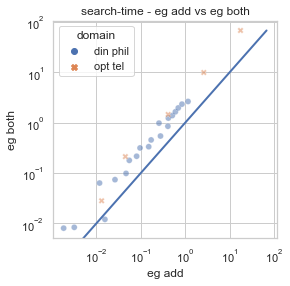

In [77]:
attr = 'search-time'
df_1 = eg_add
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

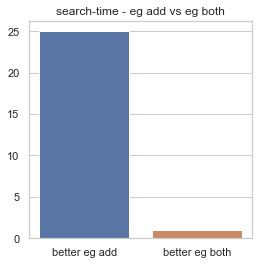

In [78]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

Count of how many times one setup is better than the other

In [44]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

w: 1.0 
p: 1.1920928955078125e-07
Significant difference between eg add and eg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


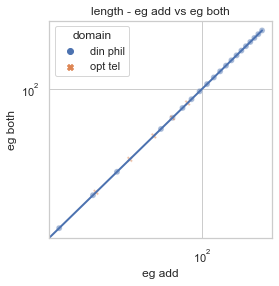

In [45]:
attr = 'length'
df_1 = eg_add
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

Count of how many times one setup is better than the other

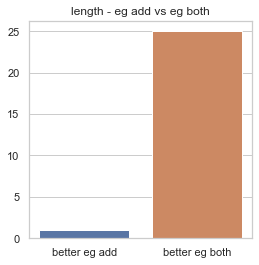

In [46]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

In [47]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

Count of failed problems for each approach

In [48]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'eg add', label_2 = 'eg both')

{'eg add': '0.00%', 'eg both': '3.85%'}

#### Eager greedy: cg vs both

Time performances

In [49]:
attr = 'search-time'
df_1 = eg_cg
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

KeyError: "None of [Index(['eg cg'], dtype='object')] are in the [columns]"

Count of how many times one setup is better than the other

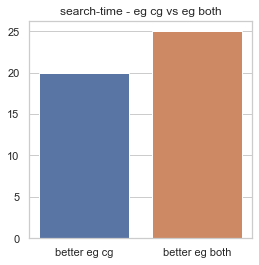

In [50]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

In [51]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

plan length performance

In [52]:
attr = 'length'
df_1 = eg_cg
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

KeyError: "None of [Index(['eg cg'], dtype='object')] are in the [columns]"

In [53]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

Count of how many times one setup is better than the other

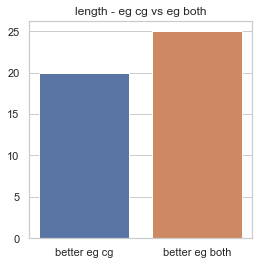

In [54]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

Count of failed problems for each approach

In [55]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'eg cg', label_2 = 'eg both')

{'eg cg': '100.00%', 'eg both': '100.00%'}

## Comparison between search strategies
The couples of setups we compare in the next cells have constant heuristic and different search strategy.

#### lazy greedy add vs eager greedy add

time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


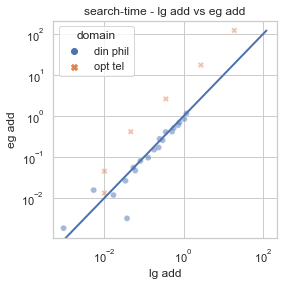

In [56]:
attr = 'search-time'
df_1 = lg_add
df_2 = eg_add

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

Count of how many times one setup is better than the other

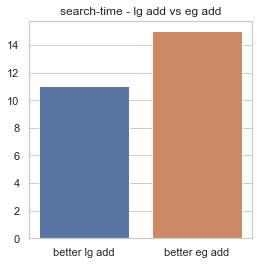

In [57]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

In [58]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

w: 156.0 
p: 0.6204162095825689
Same distribution between lg add and eg add in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


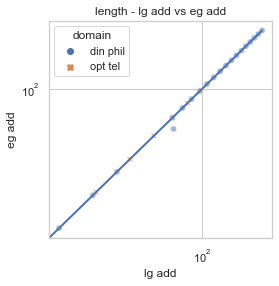

In [59]:
attr = 'length'
df_1 = lg_add
df_2 = eg_add

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

In [60]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

w: 0.0 
p: 0.31731050786291415
Same distribution between lg add and eg add in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of how many times one setup is better than the other

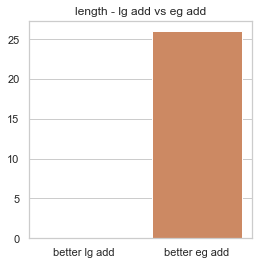

In [61]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

In [62]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

{'lg add': '0.00%', 'eg add': '0.00%'}

#### lazy greedy cg vs eager greedy cg

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


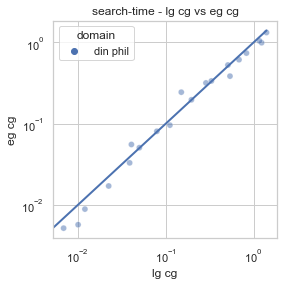

In [63]:
attr = 'search-time'
df_1 = lg_cg
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'eg cg')

Count of how many times one setup is better than the other

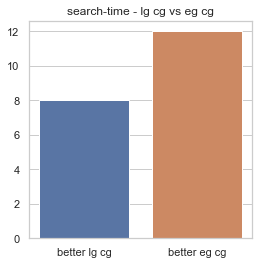

In [64]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'eg cg')

In [65]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'eg cg')

w: 65.0 
p: 0.14290618896484375
Same distribution between lg cg and eg cg in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


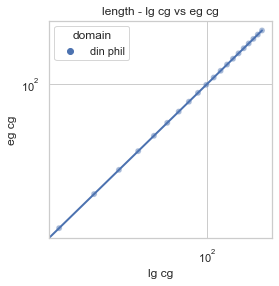

In [66]:
attr = 'length'
df_1 = lg_cg
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'eg cg')

Count of how many times one setup is better than the other

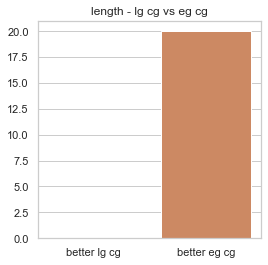

In [67]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'eg cg')

In [68]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add', label_2 = 'eg add')

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [69]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'lg cg', label_2 = 'eg cg')

{'lg cg': '0.00%', 'eg cg': '0.00%'}

#### lg both vs eg both

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


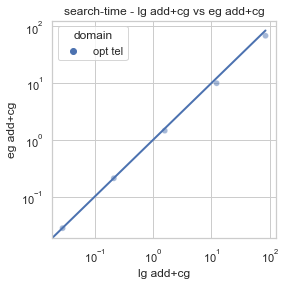

In [70]:
attr = 'search-time'
df_1 = lg_both
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add+cg', label_2 = 'eg add+cg')

Count of how many times one setup is better than the other

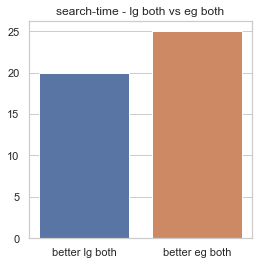

In [71]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg both', label_2 = 'eg both')

In [72]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add+cg', label_2 = 'eg add+cg')

w: 0.0 
p: 0.0625
Same distribution between lg add+cg and eg add+cg in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


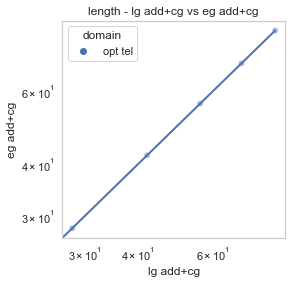

In [73]:
attr = 'length'
df_1 = lg_both
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'lg add+cg', label_2 = 'eg add+cg')

Count of how many times one setup is better than the other

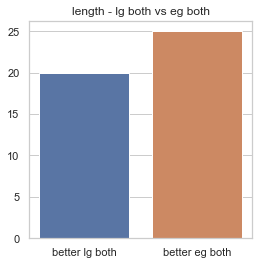

In [74]:
get_difference(df_1, df_2, attr, exclude=None, label_1 = 'lg both', label_2 = 'eg both')

In [75]:
wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'lg add+cg', label_2 = 'eg add+cg')

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [76]:
count_fails(df_1, df_2, attr, exclude=None, label_1 = 'lg both', label_2 = 'eg both')

{'lg both': '80.00%', 'eg both': '80.00%'}